# Step 5.5: Deep Learning - Latent Space

In [1]:
# Import standard libraries
import os

# Import installed libraries
import ipywidgets
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from sklearn import preprocessing

import tensorflow.keras as keras

from tqdm.keras import TqdmCallback

# Matplotlib settings
# Set the dark mode and the font size and style
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
# Let's mount the Google Drive, where we store files and models (if applicable, otherwise work
# locally)
try:
    from google.colab import drive
    drive.mount('/gdrive')
    core_path = "/gdrive/MyDrive/Colab/asteroid_taxonomy/"
except ModuleNotFoundError:
    core_path = ""

In [3]:
# Load the level 2 asteroid data
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

In [4]:
# Allocate the spectra to one array and the classes to another one
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Main_Group"].to_list())
asteroids_y_bus = np.array(asteroids_df["Bus_Class"].to_list())

In [5]:
# In this example we create a single test-training split with a ratio of 0.8 / 0.2
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Create a simple, single train / test split
for train_index, test_index in sss.split(asteroids_X, asteroids_y):
    
    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_y[train_index], asteroids_y[test_index]
    y_train_bus, y_test_bus = asteroids_y_bus[train_index], asteroids_y_bus[test_index]

## Scaling the data

The data are already scaled at 550 nm. However, in our case we re-scale all spectra from 0 to 1. Due to the already present pre-processing, no exhaustive processing is needed.

Further, we also need to reshape the data for the 1D ConvNets. Normally, one would expect to use an array with m rows (number of samples), each with n dimensions (number of features, e.g., time stamps). However, for 1D ConvNets keras expectes a structure like (m, n, 1). Consequently, each individial feature needs to be stores as a single dimensional array.

In [6]:
# Scale the training and test data
X_train_scaled = \
    np.array([(k - np.min(k)) / (np.max(k - np.min(k))) for k in X_train]).reshape(-1,49,1)
X_test_scaled = \
    np.array([(k - np.min(k)) / (np.max(k - np.min(k))) for k in X_test]).reshape(-1,49,1)

In [7]:
# Let's print the results
n_inputs = asteroids_X.shape[1]
print(f"Number of inputs: {n_inputs}")

# Take a look at the shape of the scaled dataset. We have 1071 spectra with 49 features, but each
# feature (reflectance for a particular wavelength) is stored as a 1D array (1).
print(X_train_scaled.shape)

Number of inputs: 49
(1071, 49, 1)


## Building the Autoencoder

Now we create a ConvNet Autoencoder. Since we have a rather small dataset we

In [8]:
# Let's create an autoencoder
n_bottleneck = 2

# Input layer
in_layer = keras.layers.Input(shape=(n_inputs,1))

# First hidden layer (encoder side)
enc_hid_lay1 = keras.layers.Conv1D(4, 3, activation="relu", padding="same")(in_layer)

# Second hidden layer (encoder side)
enc_hid_lay2 = keras.layers.Conv1D(8, 3, activation="relu", padding="same")(enc_hid_lay1)

# Encoder ("Bottleneck" of the Autoencoder)
bottleneck_lay = keras.layers.Flatten()(enc_hid_lay2)
bottleneck_lay = keras.layers.Dense(n_bottleneck)(bottleneck_lay)


# The original shape must be restored and reshaped accordingly
reset_lay = keras.layers.Dense(49)(bottleneck_lay)
reshape_lay = keras.layers.Reshape((49,1))(reset_lay)

# First and second hidden decoder layers
dec_hid_lay1 = keras.layers.Conv1DTranspose(8, 3, strides=1,
                                            activation="relu", padding="same")(reshape_lay)
dec_hid_lay2 = keras.layers.Conv1DTranspose(4, 3, strides=1,
                                            activation="relu", padding="same")(dec_hid_lay1)

# Ouput layer (same size as input layer)
out_layer = keras.layers.Conv1D(1, 1, activation="sigmoid", padding="same")(dec_hid_lay2)

# Create model
model = keras.models.Model(inputs=in_layer, outputs=out_layer)

# Compile the model. Use the Mean Squred Error as the loss function. Background: An Autoencoder is
# a regression function that maps the input value directly to the output values
model.compile(optimizer='adam', loss='mse')

# Show summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 49, 1)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 49, 4)             16        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 49, 8)             104       
_________________________________________________________________
flatten (Flatten)            (None, 392)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 786       
_________________________________________________________________
dense_1 (Dense)              (None, 49)                147       
_________________________________________________________________
reshape (Reshape)            (None, 49, 1)             0     

In [9]:
# Train the model
end_epoch = 100
batch_size = 32
history = model.fit(X_train_scaled, X_train_scaled,
                    epochs=end_epoch,
                    batch_size=batch_size,
                    verbose=0,
                    validation_data=(X_test_scaled, X_test_scaled),
                    callbacks=[TqdmCallback(verbose=2)])

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

  0%|          | 0.00/34.0 [00:00<?, ?batch/s]

## The loss function

Let's show the loss of the training and test data. As you can see, the minimum-plateau is reached quite fast. The test data performs slightly better than the training data, since the loss results for the training data are based on an average of the batch size. The test results are based on all data.

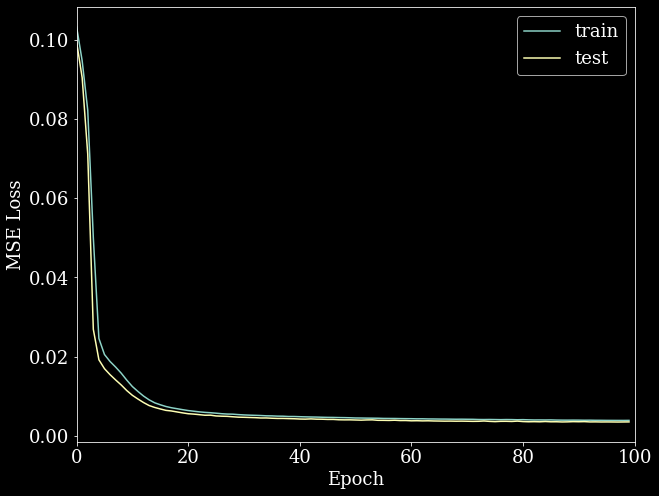

In [10]:
# plot the training and validation loss
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

# Add legend and labels
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")

# Limit the x axis
plt.xlim(0, end_epoch)

# ... aaaaand plot!
plt.show()

## Signal Reconstruction

... can be done by using the entire model to predict the output spectra. The following code snippet takes a signal (change the index value in the first line to use any other signal) and predicts the Autoencoder based spectrum.

As one can see, the results are "quite ok" but far from perfect. The shape of the spectra can be reproduced. However, the signals are quite noisy. The question is now: Do we have a low-dimensional clustering?

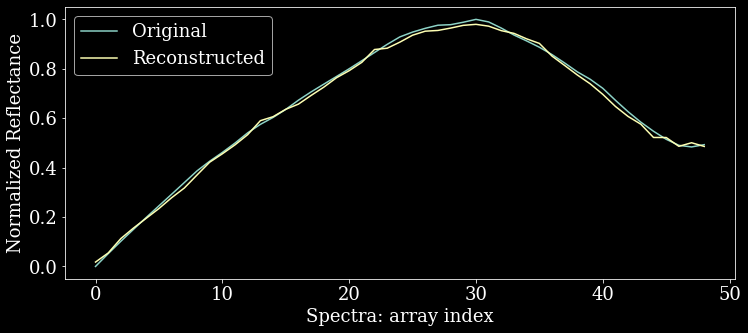

In [11]:
# Which index shall be displayed?
index_val = 100

# plot the training and reconstructed data
plt.figure(figsize=(12,5))
plt.plot(X_train_scaled[index_val], label='Original')
plt.plot(model.predict(X_train_scaled)[index_val], label='Reconstructed')

# Add legend and labels
plt.legend()
plt.xlabel("Spectra: array index")
plt.ylabel("Normalized Reflectance")

# ... aaaaand plot!
plt.show()

In [12]:
# Create dataframe that contains the encoder values (2 values at bottleneck) and the corresponding
# class to see whether the autoencoder values cluster in a way

# Build the encoder
encoder = keras.models.Model(inputs=in_layer, outputs=bottleneck_lay)

# Encode the trained spectra
X_train_encoded = encoder.predict(X_train_scaled)

# Create the dataframe
encoded_train_df = pd.DataFrame(np.hstack((X_train_encoded,
                                           y_train[np.newaxis].transpose(),
                                           y_train_bus[np.newaxis].transpose())),
                                columns=["enc1", "enc2", "Main_Group", "Bus_Class"])

# Change the dtype to float
encoded_train_df.loc[:, "enc1"] = encoded_train_df["enc1"].astype(float)
encoded_train_df.loc[:, "enc2"] = encoded_train_df["enc2"].astype(float)

## Low Dimensional Space

Now let's take a look at the 2D Autoencoder space. The main group classes are colored and afterwards plotted. One can see that the C and S class can be distinguished well. The C Class shows also local clusters that would be investigated further. The group "other" (outlier) are separated from the rest in two "regions" and the X class overlaps with the S and C class.

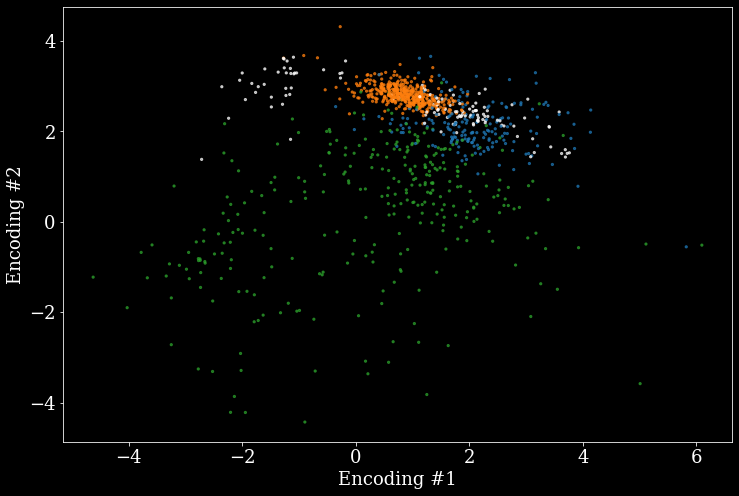

In [13]:
# Plot now the autoencoder values for the Main Group

# Create a dictionary to color the classes
color_dict = {'Other': 'w',
              'S': 'tab:orange',
              'C': 'tab:green',
              'X': 'tab:blue'}

# Set a plot
plt.figure(figsize=(12,8))

# Create a scatter plot with the encoder values and assign the colors to the corresponding classes
plt.scatter(encoded_train_df["enc1"],
            encoded_train_df["enc2"],
            marker='o',
            s=5,
            alpha=0.7,
            color=encoded_train_df.apply(lambda x: color_dict.get(x["Main_Group"]), axis=1).values)

# Set xlabels
plt.xlabel("Encoding #1")
plt.ylabel("Encoding #2")

# Save the image and show it, too
plt.savefig("asteroid_spectra_AE_ConvNet_2dim.png")
plt.show()

In [1]:
# Let's create now an interactive plot for the Bus Class! Do we see clusters in the Bus-Class
# domain?
%matplotlib inline

# In our plot we will plot only the "top 20" Bus Classes (sorted by number)
top_bus = encoded_train_df.groupby('Bus_Class')['Main_Group'].count().nlargest(20)
bus_classes = sorted(top_bus.index)

# Filter the dataframe
encoded_train_df = encoded_train_df[encoded_train_df["Bus_Class"].isin(top_bus.index)].copy()

# Get a list of all Bus Classes
bus_classes = sorted(encoded_train_df["Bus_Class"].unique())

# Create a Selection widget
# Note: Press Shift or Cntrl (Windows) / CMD (MacOS) to choose multiple classes
selector = ipywidgets.SelectMultiple(options = bus_classes,
                                     value = [bus_classes[0]],
                                     rows = 10,
                                     description = 'Variables',
                                     disabled = False)

# Get the selected items
output = ipywidgets.Output()
display(selector)
display(output)

# Create a colormap, the colors and create a color dictionary
cmap = plt.get_cmap('tab20')
colors = cmap(np.linspace(0, 1, len(bus_classes)))
for k, c in zip(bus_classes, colors):
    color_dict[k] = c

# Set the dark mode and the font size and style
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

# Set a function for the (interactive) plots
def plot_encoding(widg):

    # Get the selected choices
    choices = widg['new']

    # Filter the dataframe based on the selection
    data = encoded_train_df.loc[encoded_train_df["Bus_Class"].isin(choices)] if choices \
               else encoded_train_df
    output.clear_output(wait=True)

    with output:

        # Create a "wide screen figure"
        fig, ax = plt.subplots(figsize=(20,8))

        # Plot the encoding values within a for loop to create easily a legend for each group
        for bus_k in np.unique(data["Bus_Class"]):

            ax.scatter(data.loc[data["Bus_Class"] == bus_k]["enc1"],
                       data.loc[data["Bus_Class"] == bus_k]["enc2"],
                       marker = 'o',
                       s = 15,
                       alpha = 0.7,
                       color = color_dict.get(bus_k),
                       label = bus_k)

        # Create the legend
        ax.legend()

        # Set labels
        plt.xlabel("Encoding #1")
        plt.ylabel("Encoding #2")

        # Set limits
        plt.xlim(np.min(encoded_train_df["enc1"]), np.max(encoded_train_df["enc1"]))
        plt.ylim(np.min(encoded_train_df["enc2"]), np.max(encoded_train_df["enc2"]))

        plt.show()

# Create an interactive session!
selector.observe(plot_encoding, names='value')

NameError: name 'encoded_train_df' is not defined

## Summary & Outlook

Further scientific work could focus on the encoding domain. E.g., one could increase the number of bottleneck layers to preserve information. Further, one could afterwards apply miscellaneous clustering algorithms (like GMM) in the encoding domain to determine the number of clusters, based on this purely un-supervised approach